In [9]:
import os
import numpy as np

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [10]:
X_train = np.load(f'..\\data\\processed\\X_train.npy')
X_test = np.load(f'..\\data\\processed\\X_val.npy')
y_train = np.load(f'..\\data\\processed\\y_train.npy')
y_test = np.load(f'..\\data\\processed\\y_val.npy')

In [11]:
# params to sweep over
param_grid = {
    'shrinkage': np.linspace(0, 1, 100),
    'solver': ['lsqr']
}

# lda => gda with same covariance matrices
lda = LinearDiscriminantAnalysis()

# cv here defines 5-fold cross-validation
grid_search_lda = GridSearchCV(
    lda, 
    param_grid, 
    cv=5, 
    verbose=1, 
    n_jobs=-1
    )
grid_search_lda.fit(X_train, y_train)

print("Best LDA parameters:", grid_search_lda.best_params_)
lda_best = grid_search_lda.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best LDA parameters: {'shrinkage': np.float64(0.0), 'solver': 'lsqr'}


Test Accuracy (LDA): 0.8275
Classification Report (LDA):
                  precision    recall  f1-score   support

        no_tumor       0.78      0.84      0.80        79
    glioma_tumor       0.87      0.81      0.84       165
meningioma_tumor       0.73      0.73      0.73       165
 pituitary_tumor       0.91      0.93      0.92       165

        accuracy                           0.83       574
       macro avg       0.82      0.83      0.82       574
    weighted avg       0.83      0.83      0.83       574



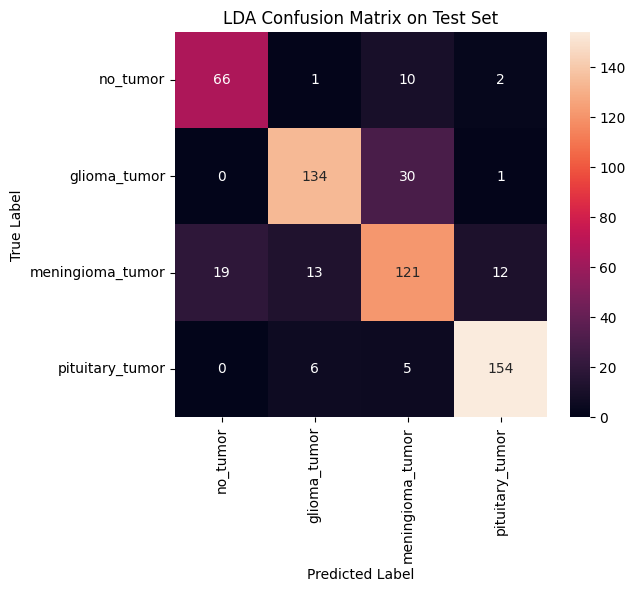

In [12]:
y_pred_test_gda = lda_best.predict(X_test)

categories = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

accuracy_gda = accuracy_score(y_test, y_pred_test_gda)
print(f"Test Accuracy (LDA): {accuracy_gda:.4f}")
print("Classification Report (LDA):")
print(classification_report(y_test, y_pred_test_gda, target_names=categories))

conf_mat_gda = confusion_matrix(y_test, y_pred_test_gda)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_gda, annot=True, fmt='d', 
            xticklabels=categories, yticklabels=categories)
plt.title("LDA Confusion Matrix on Test Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

LDA Inference time for 574 samples: 0.0010 seconds
LDA Average inference time per sample: 0.0018 ms
LDA Model memory usage: 87250 bytes (~85.21 KB)


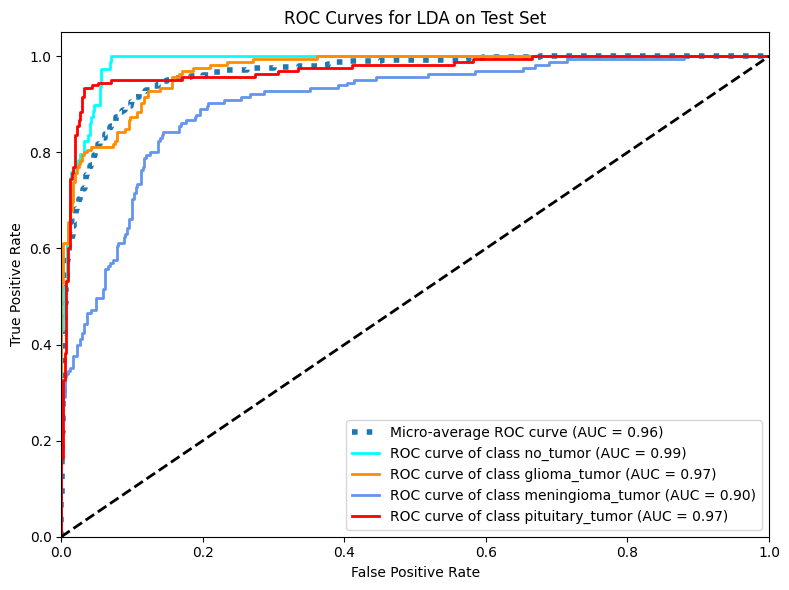

In [13]:
import time
import pickle
import sys
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

start_time = time.time()
y_pred_test_lda = lda_best.predict(X_test)
end_time = time.time()
total_time_lda = end_time - start_time
avg_inference_time_lda = (total_time_lda / len(X_test)) * 1000

print(f"LDA Inference time for {len(X_test)} samples: {total_time_lda:.4f} seconds")
print(f"LDA Average inference time per sample: {avg_inference_time_lda:.4f} ms")

lda_model_bytes = pickle.dumps(lda_best)
memory_usage_lda = sys.getsizeof(lda_model_bytes)
memory_usage_lda_kb = memory_usage_lda / 1024
print(f"LDA Model memory usage: {memory_usage_lda} bytes (~{memory_usage_lda_kb:.2f} KB)")

categories = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
n_classes = len(categories)

y_test_binarized = label_binarize(y_test, classes=range(n_classes))

y_score_lda = lda_best.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_lda[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score_lda.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for LDA
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         linestyle=":", linewidth=4)
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {categories[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for LDA on Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [14]:
# params to sweep over
param_grid = {
    'reg_param': np.linspace(0, 1, 100)
}

# qda => gda with different covariance matrices
qda = QuadraticDiscriminantAnalysis()

# cv here defines 5-fold cross-validation
grid_search_qda = GridSearchCV(
    qda, 
    param_grid, 
    cv=5, 
    verbose=1, 
    n_jobs=-1
    )
grid_search_qda.fit(X_train, y_train)

print("Best QDA parameters:", grid_search_qda.best_params_)
qda_best = grid_search_qda.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best QDA parameters: {'reg_param': np.float64(0.0)}


Test Accuracy (QDA): 0.8885
Classification Report (QDA):
                  precision    recall  f1-score   support

        no_tumor       0.82      0.82      0.82        79
    glioma_tumor       0.88      0.98      0.92       165
meningioma_tumor       0.87      0.78      0.82       165
 pituitary_tumor       0.95      0.94      0.95       165

        accuracy                           0.89       574
       macro avg       0.88      0.88      0.88       574
    weighted avg       0.89      0.89      0.89       574



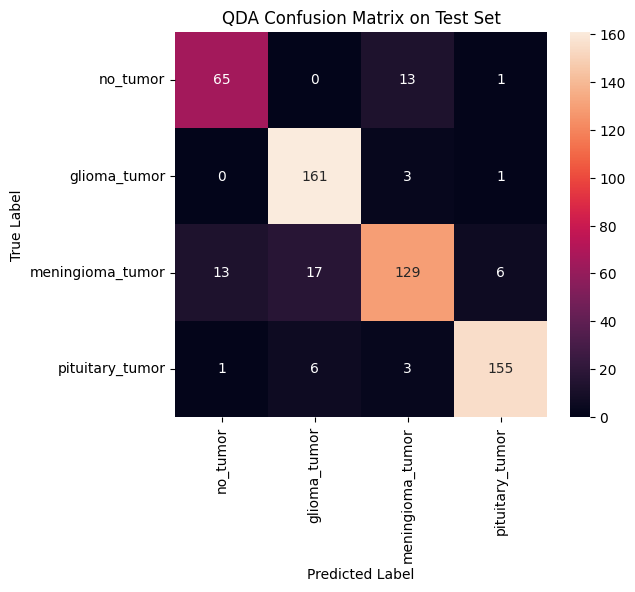

In [15]:
y_pred_test_gda = qda_best.predict(X_test)

accuracy_gda = accuracy_score(y_test, y_pred_test_gda)
print(f"Test Accuracy (QDA): {accuracy_gda:.4f}")
print("Classification Report (QDA):")
print(classification_report(y_test, y_pred_test_gda, target_names=categories))

conf_mat_gda = confusion_matrix(y_test, y_pred_test_gda)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_gda, annot=True, fmt='d', 
            xticklabels=categories, yticklabels=categories)
plt.title("QDA Confusion Matrix on Test Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

QDA Inference time for 574 samples: 0.0030 seconds
QDA Average inference time per sample: 0.0052 ms
QDA Model memory usage: 327322 bytes (~319.65 KB)


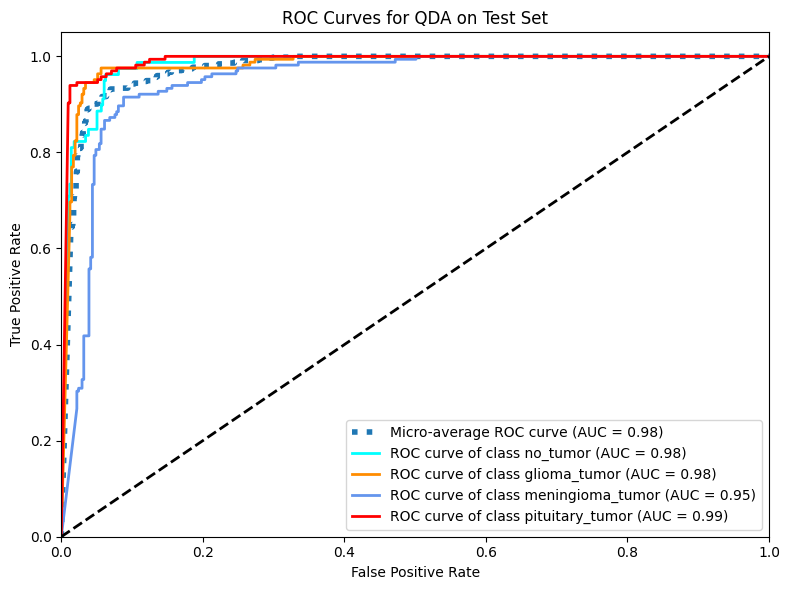

In [16]:
import time
import pickle
import sys
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

start_time = time.time()
y_pred_test_qda = qda_best.predict(X_test)
end_time = time.time()
total_time_qda = end_time - start_time
avg_inference_time_qda = (total_time_qda / len(X_test)) * 1000  

print(f"QDA Inference time for {len(X_test)} samples: {total_time_qda:.4f} seconds")
print(f"QDA Average inference time per sample: {avg_inference_time_qda:.4f} ms")

qda_model_bytes = pickle.dumps(qda_best)
memory_usage_qda = sys.getsizeof(qda_model_bytes)
memory_usage_qda_kb = memory_usage_qda / 1024
print(f"QDA Model memory usage: {memory_usage_qda} bytes (~{memory_usage_qda_kb:.2f} KB)")

categories = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
n_classes = len(categories)

y_test_binarized = label_binarize(y_test, classes=range(n_classes))

y_score_qda = qda_best.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_qda[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score_qda.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         linestyle=":", linewidth=4)
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {categories[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for QDA on Test Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
